# Nonstationary Off-Policy Quantile CS Demo
NB: Install [numba](http://numba.pydata.org/) for a speedup.

Note off-policy quantile identification functions are not bounded, and in the simulation below, the variance is infinite.

In [1]:
class LowerCSBase(object):
    def __init__(self):
        super().__init__()
        
    def addobs(self, x):
        raise NotImplementedError
        
    def getci(self, alpha):
        raise NotImplementedError

class CountableDiscreteThetaBase(LowerCSBase):
    def __init__(self, *, lambdamax=1/2, xi=8/5, **kwargs):
        from math import log1p, exp
        import scipy.special as sc
        
        super().__init__(**kwargs)
        
        assert 0 < lambdamax <= 1 + sc.lambertw(-exp(-2))
        assert 1 < xi
        
        self.lambdamax = lambdamax
        self.xi = xi
        self.logxi = log1p(xi - 1)

    def getci(self, alpha):
        return self.__lblogwealth(alpha=alpha)

    def __get_lam_sqrttp1(self, j):
        from math import log, exp
        
        logden = (j + 1/2) * self.logxi - 1/2 * log(self.t + 1)
        return self.lambdamax * exp(-logden)
    
    def get_log_weight(self, j):
        raise NotImplementedError
        
    def get_log_remaining_weight(self, j):
        raise NotImplementedError
    
    def __logwealthmix(self, *, theta, thres):
        from math import sqrt
        import numpy as np
        from scipy.special import logsumexp
        
        s = self.getS(theta)        
        sqrttp1 = sqrt(self.t + 1)
        y = s / sqrttp1 
        
        logEs = np.array([ self.__get_lam_sqrttp1(j) * y - self.getV(theta, self.__get_lam_sqrttp1(j)) for j in range(2) ])
        logws = np.array([ self.get_log_weight(j) for j in range(2) ])
        j = len(logEs)
        
        while True:
            lowerbound = logsumexp(a=logEs+logws)
            
            if lowerbound >= thres:
                return lowerbound
            
            # quasiconcave after the maximum, otherwise lower bound variance with 0
            logupperexp = logEs[-1] if logEs[-1] < max(logEs[:-1]) else self.__get_lam_sqrttp1(j) * y
            upperbound = logsumexp(a=[lowerbound, self.get_log_remaining_weight(j) + logupperexp])
            
            if upperbound < thres:
                return upperbound
            
            logEs = np.append(logEs, self.__get_lam_sqrttp1(j) * y - self.getV(theta, self.__get_lam_sqrttp1(j)))
            logws = np.append(logws, self.get_log_weight(j))
            j += 1
    
    def __lblogwealth(self, *, alpha):
        from math import log
        import scipy.optimize as so

        assert 0 < alpha < 1, alpha
        thres = -log(alpha)

        mintheta = 0
        logwealthmintheta = self.__logwealthmix(theta=mintheta, thres=thres)
        if logwealthmintheta <= thres:
            return mintheta
        
        maxtheta = 1
        logwealthmaxtheta = self.__logwealthmix(theta=maxtheta, thres=thres)
        if logwealthmaxtheta >= thres:
            return maxtheta

        res = so.root_scalar(f = lambda theta: self.__logwealthmix(theta=theta, thres=thres) - thres,
                             method = 'brentq',
                             bracket = [ mintheta, maxtheta ])
        assert res.converged, res
        
        return res.root
    
    def getS(self, theta):
        raise NotImplementedError
        
    def getV(self, theta, lamsqrttp1):
        raise NotImplementedError
        
class RobustThetaMixture(CountableDiscreteThetaBase):
    def __init__(self, *, eta=0.95, r=2, **kwargs):
        from math import log1p
        import mpmath 

        assert 0 < eta < 1
        assert r > 1
        
        self.eta = eta
        self.r = r
        self.scalefac = 1/2 * (1 + mpmath.fp.polylog(r, eta) / (eta * mpmath.fp.zeta(r)))
        assert 0 < self.scalefac < 1, self.scalefac
        self.logscalefac = log1p(self.scalefac - 1)
        self.t = 0
        
        super().__init__(**kwargs)
        
        self.logxim1 = log1p(self.xi - 2)

    def get_log_weight(self, j):
        return self.logscalefac + self.logxim1 - (1 + j) * self.logxi
    
    def get_log_remaining_weight(self, j):
        return self.logscalefac - j * self.logxi 

# https://stackoverflow.com/questions/7133885/fastest-way-to-grow-a-numpy-numeric-array
class NumpyAppend(object):
    import numpy as np
    
    def __init__(self, shape=(0,), dtype=np.float64):
        import numpy as np
        """First item of shape is ignored, the rest defines the shape"""
        self.shape = shape
        self.data = np.zeros((100,*shape[1:]),dtype=dtype)
        self.capacity = 100
        self.size = 0

    def add(self, x):
        if self.size == self.capacity:
            import numpy as np

            self.capacity *= 4
            newdata = np.zeros((self.capacity,*self.data.shape[1:]))
            newdata[:self.size] = self.data
            self.data = newdata

        self.data[self.size] = x
        self.size += 1

    def view(self):
        return self.data[:self.size]

class IdentifiableOffPolicyBase(object):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.W = NumpyAppend()
        self.R = NumpyAppend()
        self.t = 0
        
    def addobs(self, x):
        w, r = x
        assert 0 <= w
        
        self.W.add(w)
        self.R.add(r)
        self.t += 1
    
# for numba
import math as mathzee
    
class QuantileOffPolicyLowerCS(IdentifiableOffPolicyBase, RobustThetaMixture):
    def __init__(self, *, q, **kwargs):
        assert 0 < q < 1
        
        super().__init__(**kwargs)
        
        self.q = q
        self.rmin = 0
    
    def __thetaForward(self, theta):
        if theta < 1e-6:
            return 1 - 1 / theta # + O(theta)
        elif theta > 1 - 1e-6:
            return 1 / (1 - theta) - 1 # + O((theta-1))
        else:
            return (2 * theta - 1) / (theta - theta**2)

    def addobs(self, x):
        super().addobs(x)
        
        _, r = x
        self.rmin = min(self.rmin, r)
        
    def getci(self, alpha):
        from math import inf
        
        rawci = super().getci(alpha)
        assert 0 <= rawci <= 1
        
        if rawci == 0:
            return -inf
        elif rawci == 1:
            return inf
        else:
            return self.__thetaForward(rawci)

    # G(theta, W_s, R_s) = (W_s 1_{R_s >= theta} + (q - 1))/2

    def getS(self, theta):
        if self.t == 0:
            return 0
        
        if theta == 0:
            # g[t] = ( W[t] + q - 1 ) / 2
            return ( self.W.view().sum() + self.t * (self.q - 1) ) / 2
        elif theta == 1:
            # g[t] = (q - 1) / 2
            return self.t * (self.q - 1) / 2
        else:
            return self.__actualgetS(self.__thetaForward(theta))

    def __actualgetS(self, theta):
        import numpy as np
                
        w = self.W.view()
        r = self.R.view()
        return (w[r >= theta].sum() + self.t * (self.q - 1)) / 2
        
    import importlib.util
    import sys
    
    if 'numba' in sys.modules or importlib.util.find_spec('numba') is not None:
        print(f'using numba for acceleration')
        
        from numba import guvectorize, float64
        
        @staticmethod
        @guvectorize([(float64[:], float64[:], float64, float64, float64, float64, float64[:])], '(n),(n),(),(),(),()->()',nopython=True,fastmath=True)
        def getVnumba(W, R, theta, lamsqrttp1, q, sqrttp1, res):
            sumg = 0
            v = 0
            i = 0
            belowfac = (q - 1) / (2 * sqrttp1)
            scalefac = 1 / (2 * sqrttp1)
            ghat1 = 0

            while i + 4 < W.shape[0]:
                g1 = belowfac + (W[i] * scalefac if R[i] >= theta else 0)
                g2 = belowfac + (W[i+1] * scalefac if R[i+1] >= theta else 0)
                g3 = belowfac + (W[i+2] * scalefac if R[i+2] >= theta else 0)
                g4 = belowfac + (W[i+3] * scalefac if R[i+3] >= theta else 0)

                ghat2 = min(scalefac, (sumg + g1) / (i + 1))
                ghat3 = min(scalefac, (sumg + g1 + g2) / (i + 2))
                ghat4 = min(scalefac, (sumg + g1 + g2 + g3) / (i + 3))
                
                v += lamsqrttp1 * (g1 - ghat1) - mathzee.log1p(lamsqrttp1 * (g1 - ghat1))
                v += lamsqrttp1 * (g2 - ghat2) - mathzee.log1p(lamsqrttp1 * (g2 - ghat2))
                v += lamsqrttp1 * (g3 - ghat3) - mathzee.log1p(lamsqrttp1 * (g3 - ghat3))
                v += lamsqrttp1 * (g4 - ghat4) - mathzee.log1p(lamsqrttp1 * (g4 - ghat4))
                sumg += g1 + g2 + g3 + g4
                i += 4
                ghat1 = min(scalefac, sumg / i)

            while i < W.shape[0]:
                g1 = belowfac + (W[i] * scalefac if R[i] >= theta else 0)
                v += lamsqrttp1 * (g1 - ghat1) - mathzee.log1p(lamsqrttp1 * (g1 - ghat1))
                sumg += g1
                i += 1
                ghat1 = min(scalefac, sumg / i)

            res[0] = v
        
        def __actualgetV(self, theta, lamsqrttp1):
            from math import sqrt 
            return self.__class__.getVnumba(self.W.view(), self.R.view(), theta, lamsqrttp1, self.q, sqrt(self.t + 1))
    else:
        print(f'install numba for acceleration, falling back to numpy')

        def __actualgetV(self, theta, lamsqrttp1):
            from math import sqrt
            import numpy as np

            sqrttp1 = sqrt(self.t + 1)

            w = self.W.view()
            r = self.R.view()
            g = np.where(r >= theta, w, 0)
            g += (self.q - 1)
            g /= (2 * sqrttp1)
            ghat = np.minimum(1 / (2 * sqrttp1), np.cumsum(g) / np.arange(1, 1 + g.shape[0]))
            deltag = g[1:] - ghat[:-1]
            v = lamsqrttp1 * g[0] - np.log1p(lamsqrttp1 * g[0]) + lamsqrttp1 * deltag.sum() - np.log1p(lamsqrttp1 * deltag).sum()

            return v
        
    def getV(self, theta, lamsqrttp1):
        from math import log1p, sqrt
        
        if self.t == 0:
            return 0
        
        if theta == 0:
            return self.__actualgetV(min(-1, 2 * self.rmin), lamsqrttp1)
        elif theta == 1:
            g0 = (self.q - 1) / (2 * sqrt(self.t + 1))
            v = lamsqrttp1 * g0 - log1p(lamsqrttp1 * g0)
            return v
        else:
            return self.__actualgetV(self.__thetaForward(theta), lamsqrttp1)
        
class QuantileOffPolicyDDRM(object):
    def __init__(self, *, q, **kwargs):
        super().__init__()
        
        self.lower = QuantileOffPolicyLowerCS(q=q, **kwargs)
        self.upper = QuantileOffPolicyLowerCS(q=1 - q, **kwargs)
        
    def addobs(self, x):
        w, r = x
        assert 0 <= w
        self.lower.addobs((w, r))
        self.upper.addobs((w, -r))
        
    def getci(self, alpha):
        l = self.lower.getci(alpha/2)
        u = -self.upper.getci(alpha/2)
        return l, u

using numba for acceleration


# Pareto-Cauchy Off Policy Simulation

In [2]:
class ParetoCauchyDatagen(object):
    def __init__(self, *, gamma, shape, seed):
        from scipy.stats import pareto, cauchy
        import numpy as np
        
        assert gamma > 0
        
        super().__init__()
        
        self.scale = (shape - 1) / shape
        self.shape = shape
        self.wdist = pareto(b=shape, scale=self.scale)
        assert np.allclose(self.wdist.mean(), 1)
        self.gamma = gamma
        self.rdist = cauchy(scale=gamma)
        self.tgen = np.random.default_rng(seed)
        
    def quantile(self, q):
        return self.rdist.ppf(q)
    
    def cdf(self, v):
        return self.rdist.cdf(v)
        
    def genobs(self):
        w = self.wdist.rvs(random_state=self.tgen)
        r = self.rdist.rvs(random_state=self.tgen)
        return w, r
        
    def __str__(self):
        def vsteam(v):
            from fractions import Fraction
            vfrac = Fraction(v).limit_denominator(100)
            vstr = f'\\frac{{{vfrac.numerator}}}{{{vfrac.denominator}}}' if vfrac.denominator > 1 else f'{vfrac.numerator}'
            return vstr
        
        return f'$(x_m, \\alpha, \\gamma) = ({vsteam(self.scale)}, {vsteam(self.shape)}, {vsteam(self.gamma)})$'
    
class MixtureDatagen(object):
    def __init__(self, *, T, dg1, dg2, seed):
        import numpy as np
        
        super().__init__()
        
        self.T = T
        self.t = 0
        self.dg1 = dg1
        self.dg2 = dg2
        self.seed = seed
        self.tgen = np.random.default_rng(seed)
        
    def quantile(self, q):
        import scipy.optimize as so
        
        v1 = self.dg1.quantile(q)
        if self.t <= 1:
            return v1
        v2 = self.dg2.quantile(q)
        
        # Sum[s/T, { s, 0, t - 1}]/t
        alpha = (self.t - 1) / (2 * self.T)
        assert 0 <= alpha <= 1
        res = so.root_scalar(lambda v: -q + (1 - alpha) * self.dg1.cdf(v) + alpha * self.dg2.cdf(v), 
                             method='brentq',
                             bracket=[v1, v2])
        assert res.converged, res
        return res.root
        
    def genobs(self):
        from scipy.stats import bernoulli
        p = self.t / self.T
        draw = bernoulli.rvs(p, random_state=self.tgen)
        self.t += 1
        return self.dg1.genobs() if draw == 0 else self.dg2.genobs()
    
    def __str__(self):
        return f'{self.dg1} $\\rightarrow$ {self.dg2}'

QuantileOffPolicyDDRM CI over 1.0e+05 datapoints compute time: 1102 ms


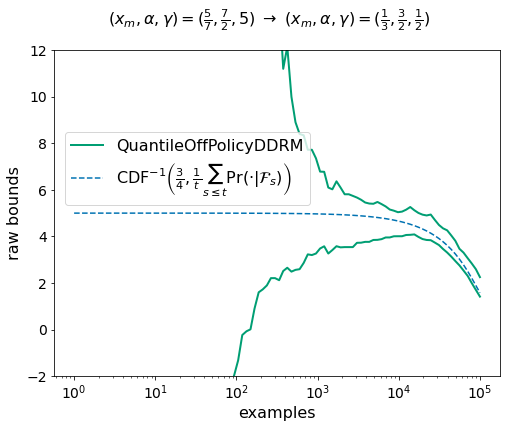

In [3]:
def megasim(*, T, datagen, q, pts=100, alpha = 0.05, savefig=None):
    import itertools
    from matplotlib import pyplot as plt
    import numpy as np
    
    assert int(pts) == pts and pts > 1
    
    strats = { f.__class__.__name__: type('',(object,),{ "impl": f, "lbz": [], "ubz": [] })() for f in [ QuantileOffPolicyDDRM(q=q) ] } 
    sumwr = 0
    trueqz = []
    tz = []
    targets = list(reversed(range(T))) if T <= pts else list(reversed(np.geomspace(1, T, num=pts)))
    rs = []
    empqz = []
    
    for t in range(T):
        w, r = datagen.genobs()
        rs.append(r)
        for _, cs in strats.items():
            cs.impl.addobs((w, r))

        if t + 1 >= targets[-1]:
            targets.pop()
            tz.append(t + 1)
            trueqz.append(datagen.quantile(q))
            #empqz.append(np.quantile(rs, q))
            
            for _, cs in strats.items():
                l, u = cs.impl.getci(alpha=0.05)
                cs.lbz.append(l)
                cs.ubz.append(u)
                
    for k, cs in strats.items():
        import time
        start = time.time()
        for _ in range(5):
            cs.impl.getci(alpha=0.05)
        end = time.time()
        print(f'{k} CI over {T:.1e} datapoints compute time: {1000*(end-start)/5:.0f} ms')

    plt.style.use('seaborn-colorblind')
    fig, ax = plt.subplots(1, 1)
    ax = [ ax ]
    fig.set_size_inches(8 * len(ax), 6)
    for n, (k, cs) in enumerate(strats.items()):
        ax[0].plot(tz, cs.lbz, label=k, color=f'C{n+1}', linewidth=2)
        ax[0].plot(tz, cs.ubz, color=f'C{n+1}', linewidth=2)
    from fractions import Fraction
    qfrac = Fraction(q).limit_denominator(10)
    ax[0].plot(tz, trueqz, linestyle='dashed', color=f'C{0}', 
               label=f'CDF$^{{-1}}\\left(\\frac{{{qfrac.numerator}}}{{{qfrac.denominator}}}, \\frac{{1}}{{t}} \\sum_{{s \\leq t}} \\mathrm{{Pr}}\\left(\\cdot | \\mathcal{{F}}_s\\right)\\right)$')
    #ax[0].plot(tz, empqz, linestyle='dashed', color=f'C{n+2}', label=f'emp CDF$^{{-1}}(\\frac{{{qfrac.numerator}}}{{{qfrac.denominator}}})$', linewidth=2)
    ax[0].set_xlabel(f'examples', fontsize=16)
    ax[0].set_ylabel('raw bounds', fontsize=16)
    ax[0].tick_params(labelsize=14)
    ax[0].set_xscale('log')
    ax[0].legend(fontsize=16, loc=(0.025, 0.525))
    ax[0].set_ylim([-2, 12])
        
    fig.suptitle(str(datagen), fontsize=16)
    
    if savefig is not None:
        plt.savefig(savefig)
        
def flass():
    T = 100000
    seed = 4545
    dg1 = ParetoCauchyDatagen(gamma=5, shape=7/2, seed=seed+1)
    dg2 = ParetoCauchyDatagen(gamma=1/2, shape=3/2, seed=seed+2)
    dg3 = MixtureDatagen(T=T, dg1=dg1, dg2=dg2, seed=seed+3)
    megasim(T=T, datagen=dg3, q=3/4, savefig='cbquantile.pdf')

flass()